# Evaluation of Municipal Growth using Random Forest Regressor

# Mean Squared Error Criterion

***
Here we are interested in analyzing firm and population growth quantitatively. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
#pd.set_option('display.width', 500)
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.notebook_repr_html', True)

#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# jupyter specific
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use = 'default'
sns.set_style("whitegrid")
sns.set_context("poster")


C:\Users\DavidMayerF\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Features and Labels

Pandas containing a series of possible features and labels were created in a previous notebook. 

**A firm growth overview label**

We define one particular label. This label is bsed on the principal component of the municipal log number of firms across production sectors and employment levels. We appeal to the principal component because we do not have any other data to motivate an aggregation by comparing for instance the  worth or employment due to each category of firms. We can estimate the rate of change in the principal component between 2012 and 2016, according to the coefficients of a PCA decomposition defined by the 2012 data.
 

### First label will be the rate of growth of first principal component of log firm numbers

C:\Users\DavidMayerF\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


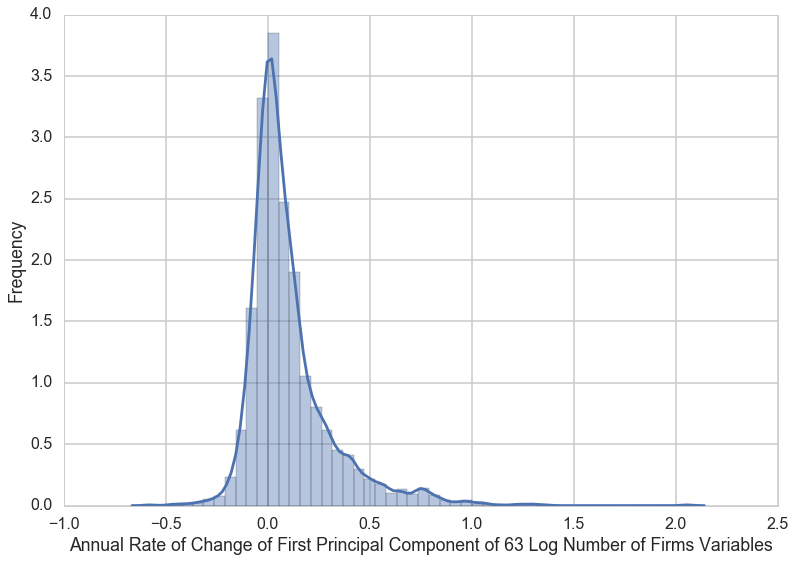

In [2]:
#Label definition
growthrates = pd.read_csv('growthrates.csv',index_col=0)
dx = pd.Series(growthrates.dx)
ax=sns.distplot(growthrates.dx)
ax.set_xlabel("Annual Rate of Change of First Principal Component of 63 Log Number of Firms Variables")
ax.set_ylabel("Frequency")
y1=dx

### Second label will be population growth

C:\Users\DavidMayerF\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


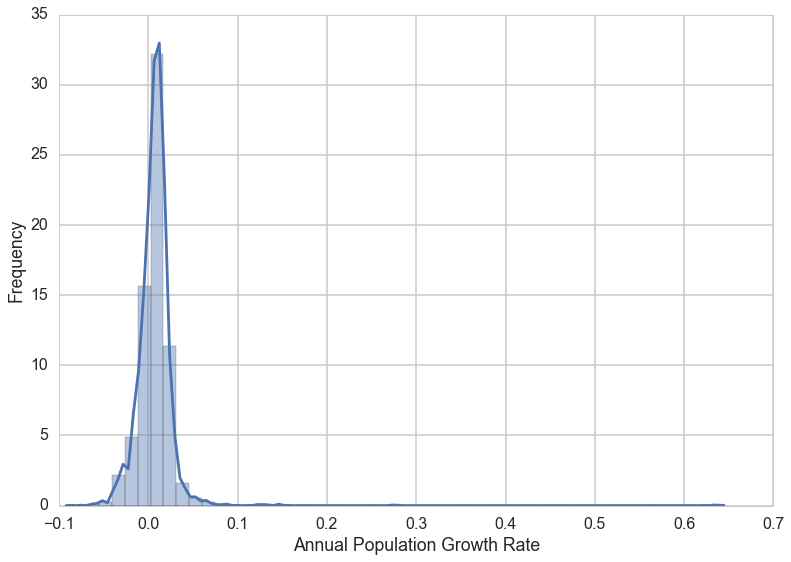

In [3]:
labels = pd.read_csv('labels.csv',index_col=0)
dptot = pd.Series(labels.dptot)
ax=sns.distplot(labels.dptot)
ax.set_xlabel("Annual Population Growth Rate")
ax.set_ylabel("Frequency")
y2=dptot

C:\Users\DavidMayerF\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\DavidMayerF\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
C:\Users\DavidMayerF\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


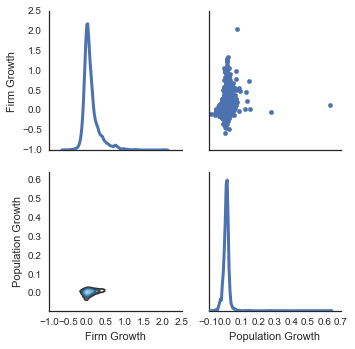

In [4]:
sns.set(style="white")

aa = growthrates[['entmun','dx']]
aa['y2']=y2
aa.columns=['entmun','Firm Growth','Population Growth']
aa=aa[['Firm Growth','Population Growth']]

g = sns.PairGrid(aa, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)


C:\Users\DavidMayerF\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\DavidMayerF\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


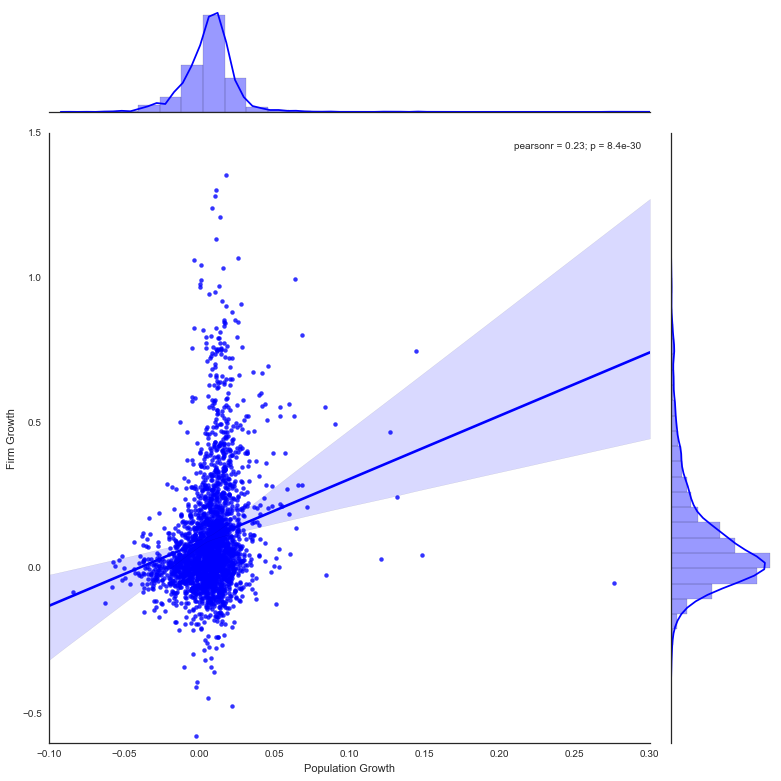

In [5]:
sns.set(style="white")

aa = growthrates[['entmun','dx']]
aa['y2']=y2
aa.columns=['entmun','Firm Growth','Population Growth']
aa=aa[['Firm Growth','Population Growth']]

g = sns.jointplot("Population Growth", "Firm Growth", data=aa, kind="reg", color="b", size=11,xlim=(-0.1, 0.3),ylim=(-0.6, 1.5))


### Features

The data set includes 2455 municipalities. The following features areused 

1) A smaller of 44 local variables. These include a) log one plus number of firms; log one plus number of firms by sectors and separately by employment levels, both at the municipal and state levels (34 variables). b) Log population, migration (proportion born in state, proportion living in the US), and marginalization, log population also at the state level (5 variables). c) Three principal components of log number of firms by sector and employment levels and two principal components for the population distribution (5 variables).

2) A set of 43 non-local variables. These include the sets of non-local variables generated from principal components x, y, z, xpop, ypop (5x7), and cummulative population rank (proportion of population living in smaller municipalities than this one; this has a correlation of 0.9357 with x), together with the 7 variables it generates. 


In [6]:
features = pd.read_csv('features.csv',index_col=0)
features.describe()


,entmun,S1E1,S1E2,S1E3,S1E4,S1E5,S1E6,S1E7,S2E1,S2E2,...,y1,y2,y3,zm3,zm2,zm1,z0,z1,z2,z3
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,...,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000
mean,19365.572301,0.524743,0.193530,0.224600,0.115109,0.069666,0.034462,0.009877,0.913590,0.421080,...,0.694030,0.836035,0.924712,0.044633,0.100471,0.237905,0.499593,0.761688,0.899121,0.954960
std,7362.851174,1.066049,0.512543,0.610367,0.401064,0.306467,0.206906,0.099269,1.001340,0.712647,...,0.286203,0.223848,0.147567,0.162339,0.188934,0.228642,0.288616,0.256798,0.151181,0.058464
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001629,0.003257,0.010993,0.000000,0.000000,0.000000,0.000000,0.009772,0.079397,0.262215
25%,14083.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.463966,0.724959,0.972313,0.000000,0.009365,0.075733,0.249796,0.621336,0.929153,0.958062
50%,20230.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,...,0.765065,0.976792,0.982085,0.004886,0.053339,0.191775,0.499593,0.910423,0.952769,0.969463
75%,24030.500000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612,0.693147,...,0.976384,0.981678,0.986564,0.017915,0.100570,0.330212,0.749389,0.939332,0.961726,0.973127
max,32058.000000,6.363028,4.143135,4.430817,3.871201,3.465736,2.708050,1.609438,6.070738,4.875197,...,0.999593,0.999593,0.999593,0.998779,0.999186,0.999186,0.999186,0.999593,0.999593,0.999593


In [7]:
X1=features[['entmun','E1','E2','E3','E4','E5','E6','E7','S1','S2','S3','S4','S5','S6','S7','S8','S9','E1ent','E2ent','E3ent','E4ent','E5ent','E6ent','E7ent','S1ent','S2ent','S3ent','S4ent','S5ent','S6ent','S7ent','S8ent','S9ent','SE','SEent','lptot10','im10','nacent10','viveu10','lptot10ent','xpop','ypop','x','y','z']]     
X1.head(2)

,entmun,E1,E2,E3,E4,E5,E6,E7,S1,S2,...,lptot10,im10,nacent10,viveu10,lptot10ent,xpop,ypop,x,y,z
0,1001,10.385482,8.027150,7.646354,5.918894,5.624018,4.983607,4.465908,2.484907,6.025866,...,13.588623,-1.768,75.3,0.9,13.98525,0.356152,0.395596,0.767066,0.558617,0.195125
1,1002,6.287859,3.295837,2.772589,2.079442,1.386294,1.098612,0.000000,0.000000,0.693147,...,10.725292,-0.463,87.5,2.0,13.98525,0.182149,0.468561,0.097378,0.325569,0.148079


In [8]:
#These features are her only for reference
X2=features[['entmun','S1E1','S1E2','S1E3','S1E4','S1E5','S1E6','S1E7','S2E1','S2E2','S2E3','S2E4','S2E5','S2E6','S2E7','S3E1','S3E2','S3E3','S3E4','S3E5','S3E6','S3E7','S4E1','S4E2','S4E3','S4E4','S4E5','S4E6','S4E7','S5E1','S5E2','S5E3','S5E4','S5E5','S5E6','S5E7','S6E1','S6E2','S6E3','S6E4','S6E5','S6E6','S6E7','S7E1','S7E2','S7E3','S7E4','S7E5','S7E6','S7E7','S8E1','S8E2','S8E3','S8E4','S8E5','S8E6','S8E7','S9E1','S9E2','S9E3','S9E4','S9E5','S9E6','S9E7','S1E1ent','S1E2ent','S1E3ent','S1E4ent','S1E5ent','S1E6ent','S1E7ent','S2E1ent','S2E2ent','S2E3ent','S2E4ent','S2E5ent','S2E6ent','S2E7ent','S3E1ent','S3E2ent','S3E3ent','S3E4ent','S3E5ent','S3E6ent','S3E7ent','S4E1ent','S4E2ent','S4E3ent','S4E4ent','S4E5ent','S4E6ent','S4E7ent','S5E1ent','S5E2ent','S5E3ent','S5E4ent','S5E5ent','S5E6ent','S5E7ent','S6E1ent','S6E2ent','S6E3ent','S6E4ent','S6E5ent','S6E6ent','S6E7ent','S7E1ent','S7E2ent','S7E3ent','S7E4ent','S7E5ent','S7E6ent','S7E7ent','S8E1ent','S8E2ent','S8E3ent','S8E4ent','S8E5ent','S8E6ent','S8E7ent','S9E1ent','S9E2ent','S9E3ent','S9E4ent','S9E5ent','S9E6ent','S9E7ent']]     
X2.head(2)

,entmun,S1E1,S1E2,S1E3,S1E4,S1E5,S1E6,S1E7,S2E1,S2E2,...,S8E5ent,S8E6ent,S8E7ent,S9E1ent,S9E2ent,S9E3ent,S9E4ent,S9E5ent,S9E6ent,S9E7ent
0,1001,1.791759,1.609438,0.693147,0.693147,0.0,0.0,0.0,5.147494,4.060443,...,1.327761,0.0,0.0,3.441047,2.960784,2.821322,2.405576,2.338364,2.286559,1.591686
1,1002,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,1.327761,0.0,0.0,3.441047,2.960784,2.821322,2.405576,2.338364,2.286559,1.591686


In [9]:
X3=features[['entmun','xpopm3','ypopm3','cumpm3','xm3','ym3','zm3','ptot10cum','xpopm2','ypopm2','cumpm2','xm2','ym2','zm2','xpopm1','ypopm1','cumpm1','xm1','ym1','zm1','xpop0','ypop0','cump0','x0','y0','z0','xpop1','ypop1','cump1','x1','y1','z1','xpop2','ypop2','cump2','x2','y2','z2','xpop3','ypop3','cump3','x3','y3','z3']]     

for name in ['x','y','z','xpop','ypop','cump'] :
    for num in ['1','2','3'] :
        X3[name+num]= X3[name+num] - X3[name+'0']
        X3[name+'m'+num]= X3[name+'0'] - X3[name+'m'+num]

print(X3[['xm3','xm2','xm1','x0','x1','x2','x0']].head(2))
X3.head(2)


C:\Users\DavidMayerF\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\DavidMayerF\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


        xm3       xm2       xm1        x0        x1        x2        x0
0  0.013436  0.008550  0.004479  0.992264  0.002036  0.004072  0.992264
1  0.657573  0.657573  0.316775  0.657573  0.140472  0.207248  0.657573


,entmun,xpopm3,ypopm3,cumpm3,xm3,ym3,zm3,ptot10cum,xpopm2,ypopm2,...,cump2,x2,y2,z2,xpop3,ypop3,cump3,x3,y3,z3
0,1001,0.126629,0.331026,0.010586,0.013436,0.192590,0.589577,0.809395,0.071254,0.330619,...,0.004886,0.004072,0.006515,0.359528,0.041938,0.511401,0.006515,0.006107,0.008143,0.372964
1,1002,0.624593,0.649023,0.250814,0.657573,0.348941,0.252850,0.227655,0.341205,0.537052,...,0.075326,0.207248,0.532980,0.676303,0.155130,0.271987,0.100163,0.247557,0.613192,0.705212


### Features 2016 (will be used to predict 2016-2020 growth)

In [10]:
features_16 = pd.read_csv('labels.csv',index_col=0)
features_16.describe()


,ent,entmun,S1_16,S2_16,S3_16,S4_16,S5_16,S6_16,S7_16,S8_16,...,ypop161,ypop162,ypop163,cum16pm3,cum16pm2,cum16pm1,cum16p0,cum16p1,cum16p2,cum16p3
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,...,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000
mean,19.256619,19365.572301,0.585352,1.018211,3.929989,5.221108,3.003291,3.439012,3.827107,3.903493,...,0.513006,0.525502,0.537768,0.499610,0.499610,0.499610,0.499610,0.500017,0.500017,0.500017
std,7.347258,7362.851174,1.027874,1.304468,1.696787,1.713260,1.779369,1.452861,1.832793,1.780273,...,0.283855,0.279018,0.274187,0.288645,0.288645,0.288645,0.288645,0.288645,0.288645,0.288645
min,1.000000,1001.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.001221,0.001629,0.002443,0.000000,0.000000,0.000000,0.000000,0.000407,0.000407,0.000407
25%,14.000000,14083.500000,0.000000,0.000000,2.708050,3.970292,1.609438,2.302585,2.484907,2.484907,...,0.269340,0.291735,0.311686,0.249796,0.249796,0.249796,0.249796,0.250204,0.250204,0.250204
50%,20.000000,20230.000000,0.000000,0.693147,3.912023,5.141664,2.833213,3.178054,3.806662,3.784190,...,0.518322,0.530945,0.538681,0.499593,0.499593,0.499593,0.499593,0.500000,0.500000,0.500000
75%,24.000000,24030.500000,0.693147,1.609438,5.068904,6.342120,4.110874,4.255588,5.049856,5.090673,...,0.758143,0.764658,0.771580,0.749389,0.749389,0.749389,0.749389,0.749796,0.749796,0.749796
max,32.000000,32058.000000,6.246107,6.575076,9.304377,10.742552,9.082393,8.967759,9.430038,9.610391,...,1.000000,1.000000,1.000000,0.999593,0.999593,0.999593,0.999593,1.000000,1.000000,1.000000


In [11]:
X116=features_16[['entmun','E1_16','E2_16','E3_16','E4_16','E5_16','E6_16','E7_16','S1_16','S2_16','S3_16','S4_16','S5_16','S6_16','S7_16','S8_16','S9_16','E1_16ent','E2_16ent','E3_16ent','E4_16ent','E5_16ent','E6_16ent','E7_16ent','S1_16ent','S2_16ent','S3_16ent','S4_16ent','S5_16ent','S6_16ent','S7_16ent','S8_16ent','S9_16ent','SE_16','SE_16ent','lptot15','im15','nacent10','viveu10','lptot15ent','xpop16','ypop16','x16','y16','z16']]     
X116.describe()

,entmun,E1_16,E2_16,E3_16,E4_16,E5_16,E6_16,E7_16,S1_16,S2_16,...,lptot15,im15,nacent10,viveu10,lptot15ent,xpop16,ypop16,x16,y16,z16
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,...,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000
mean,19365.572301,5.955061,2.952630,2.615861,1.291896,1.024696,0.763911,0.547941,0.585352,1.018211,...,9.446603,0.000360,90.399308,1.283747,15.248714,-0.010169,0.001496,0.114209,0.258248,0.170836
std,7362.851174,1.657191,1.623650,1.601273,1.364646,1.300293,1.156874,1.043499,1.027874,1.304468,...,1.592267,1.000143,9.681724,1.992040,0.591534,9.717955,1.984913,0.139202,0.080937,0.071789
min,1001.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.465908,-2.228000,29.200000,-6.000000,13.474758,-9.950864,-7.533185,0.000000,0.000000,0.000000
25%,14083.500000,4.736198,1.791759,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.354086,-0.748000,87.900000,0.400000,14.898980,-6.182242,-0.889059,0.036221,0.211055,0.136118
50%,20230.000000,5.869297,2.708050,2.397895,1.098612,0.693147,0.000000,0.000000,0.000000,0.693147,...,9.494767,-0.073000,93.400000,1.100000,15.193745,-2.933446,-0.167964,0.066909,0.256251,0.171031
75%,24030.500000,7.030857,3.891820,3.465736,1.945910,1.609438,1.098612,0.693147,0.693147,1.609438,...,10.443746,0.639500,96.500000,2.300000,15.635028,2.534385,0.992353,0.129506,0.296292,0.197850
max,32058.000000,11.339619,8.950273,8.633019,6.965080,6.672033,6.232448,5.968708,6.246107,6.575076,...,14.418661,5.027000,100.000000,11.400000,16.599757,61.204193,10.019422,1.000000,1.000000,1.000000


In [12]:
#These features are her only for reference
#X216=features_16[['entmun','S1E1_16','S1E2_16','S1E3_16','S1E4_16','S1E5_16','S1E6_16','S1E7_16','S2E1_16','S2E2_16','S2E3_16','S2E4_16','S2E5_16','S2E6_16','S2E7_16','S3E1_16','S3E2_16','S3E3_16','S3E4_16','S3E5_16','S3E6_16','S3E7_16','S4E1_16','S4E2_16','S4E3_16','S4E4_16','S4E5_16','S4E6_16','S4E7_16','S5E1_16','S5E2_16','S5E3_16','S5E4_16','S5E5_16','S5E6_16','S5E7_16','S6E1_16','S6E2_16','S6E3_16','S6E4_16','S6E5_16','S6E6_16','S6E7_16','S7E1_16','S7E2_16','S7E3_16','S7E4_16','S7E5_16','S7E6_16','S7E7_16','S8E1_16','S8E2_16','S8E3_16','S8E4_16','S8E5_16','S8E6_16','S8E7_16','S9E1_16','S9E2_16','S9E3_16','S9E4_16','S9E5_16','S9E6_16','S9E7_16','S1E1ent_16','S1E2ent_16','S1E3ent_16','S1E4ent_16','S1E5ent_16','S1E6ent_16','S1E7ent_16','S2E1ent_16','S2E2ent_16','S2E3ent_16','S2E4ent_16','S2E5ent_16','S2E6ent_16','S2E7ent_16','S3E1ent_16','S3E2ent_16','S3E3ent_16','S3E4ent_16','S3E5ent_16','S3E6ent_16','S3E7ent_16','S4E1ent_16','S4E2ent_16','S4E3ent_16','S4E4ent_16','S4E5ent_16','S4E6ent_16','S4E7ent_16','S5E1ent_16','S5E2ent_16','S5E3ent_16','S5E4ent_16','S5E5ent_16','S5E6ent_16','S5E7ent_16','S6E1ent_16','S6E2ent_16','S6E3ent_16','S6E4ent_16','S6E5ent_16','S6E6ent_16','S6E7ent_16','S7E1ent_16','S7E2ent_16','S7E3ent_16','S7E4ent_16','S7E5ent_16','S7E6ent_16','S7E7ent_16','S8E1ent_16','S8E2ent_16','S8E3ent_16','S8E4ent_16','S8E5ent_16','S8E6ent_16','S8E7ent_16','S9E1ent_16','S9E2ent_16','S9E3ent_16','S9E4ent_16','S9E5ent_16','S9E6ent_16','S9E7ent_16']]  
#X216.head(2)


In [13]:
X316=features_16[['entmun','xpop16m3','ypop16m3','cum16pm3','xm163','ym163','zm163','ptot15cum','xpop16m2','ypop16m2','cum16pm2','xm162','ym162','zm162','xpop16m1','ypop16m1','cum16pm1','xm161','ym161','zm161','xpop160','ypop160','cum16p0','x160','y160','z160','xpop161','ypop161','cum16p1','x161','y161','z161','xpop162','ypop162','cum16p2','x162','y162','z162','xpop163','ypop163','cum16p3','x163','y163','z163']]     

for name in ['x','y','z'] :
    for num in ['1','2','3'] :
        X316[name+'16'+num]= X316[name+'16'+num] - X316[name+'16'+'0']
        X316[name+'m16'+num]= X316[name+'16'+'0'] - X316[name+'m16'+num]

for name in ['xpop16','ypop16','cum16p'] :
    for num in ['1','2','3'] :
        X316[name+num]= X316[name+num] - X316[name+'0']
        X316[name+'m'+num]= X316[name+'0'] - X316[name+'m'+num]

print(X316[['xm163','xm162','xm161','x160','x161','x162','x160']].head(2))

X316.describe()

C:\Users\DavidMayerF\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\DavidMayerF\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\DavidMayerF\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

      xm163     xm162     xm161      x160      x161      x162      x160
0  0.011808  0.006922  0.003664  0.991450  0.002036  0.004886  0.991450
1  0.665309  0.664902  0.279723  0.665309  0.135586  0.197883  0.665309


,entmun,xpop16m3,ypop16m3,cum16pm3,xm163,ym163,zm163,ptot15cum,xpop16m2,ypop16m2,...,cum16p2,x162,y162,z162,xpop163,ypop163,cum16p3,x163,y163,z163
count,2455.000000,2455.000000,2455.000000,2455.0,2455.000000,2455.000000,2455.000000,2.455000e+03,2455.000000,2455.000000,...,2.455000e+03,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2.455000e+03,2455.000000,2455.000000,2455.000000
mean,19365.572301,0.007910,0.037388,0.0,0.383222,0.450732,0.467732,1.426298e+07,0.005291,0.025120,...,4.071661e-04,0.329907,0.377569,0.419425,0.008317,0.037792,4.071661e-04,0.383629,0.451139,0.468139
std,7362.851174,0.004494,0.022828,0.0,0.243800,0.258771,0.272440,1.939210e+07,0.003118,0.015448,...,6.171324e-17,0.213722,0.193613,0.233457,0.004495,0.022832,6.171324e-17,0.243800,0.258771,0.272440
min,1001.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,8.700000e+01,0.000000,0.000000,...,4.071661e-04,0.000407,0.000407,0.000407,0.000407,0.000407,4.071661e-04,0.000407,0.000407,0.000407
25%,14083.500000,0.004072,0.018322,0.0,0.167956,0.222923,0.230252,1.276175e+06,0.002443,0.012215,...,4.071661e-04,0.135383,0.215594,0.219259,0.004479,0.018730,4.071661e-04,0.168363,0.223331,0.230660
50%,20230.000000,0.008550,0.032980,0.0,0.372557,0.466612,0.476792,6.339474e+06,0.005700,0.022394,...,4.071661e-04,0.322883,0.427932,0.438111,0.008958,0.033388,4.071661e-04,0.372964,0.467020,0.477199
75%,24030.500000,0.011401,0.052117,0.0,0.593648,0.690350,0.711116,1.958868e+07,0.007329,0.035423,...,4.071661e-04,0.518933,0.559853,0.632533,0.011808,0.052524,4.071661e-04,0.594055,0.690757,0.711523
max,32058.000000,0.019137,0.085505,0.0,0.810668,0.822883,0.896173,1.194916e+08,0.012622,0.059039,...,4.071661e-04,0.690554,0.605456,0.756515,0.019544,0.085912,4.071661e-04,0.811075,0.823290,0.896580


## Some definitions

In [14]:
def decisionTree(X, y, regression, max_depth=3):
    from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
    from sklearn.tree import export_graphviz
    from sklearn.externals.six import StringIO  
    from IPython.core.pylabtools import figsize
    from IPython.display import Image
    figsize(12.5, 6)
    import pydotplus
    import graphviz
    
    if regression:
        clf = DecisionTreeRegressor(max_depth=max_depth)
    else:
        clf = DecisionTreeClassifier(max_depth=max_depth)
        
    clf.fit(X, y)
    dot_data = StringIO()  
    #Changed to XX:
    export_graphviz(clf, out_file=dot_data, feature_names=list(XX.columns),
                    filled=True, rounded=True,)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())  

In [15]:
def viz(clf, clf_raw):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    
    print('Accuracy: %s' % clf.score(X_test, y_test))
    
#    try:
#        featureImportance(X_train, clf, 0.01)
#    except:
#        pass
        
    plot_learning_curve(clf_raw,'Learning curves', X_train, y_train, cv=5)
    
    #y_pred = clf.predict(X_test)
    #statistics(clf, X_train, y_train, X_test, y_test, False)


In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    from sklearn.learning_curve import learning_curve
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


def roc_curve(clf, data, regression):
    from sklearn.metrics import roc_curve, auc
    
    X_train, y_train, X_test, y_test = data
    
    if regression:
        """
        plots actual vs. predicted
        plots error
        """
        pred_train = clf.predict(X_train)
        pred_test = clf.predict(X_test) 
        plt.scatter(y_test, pred_test, color='r', label='X')
        plt.scatter(y_train, pred_train)
        plt.plot([min(min(pred_train), min(pred_test)), max(max(pred_train), max(pred_test))],
                 [min(min(y_train), min(y_test)), max(max(y_train), max(y_test))], 'k--')
        plt.title('Predicted vs. actual for train and test')
        plt.legend()
        plt.show()
        
        print('\n')
        
        plt.plot([x - y for x, y in zip(y_test, pred_test)], color='r')
        plt.plot([x - y for x, y in zip(y_train, pred_train)])
        plt.title('Actual - prediction (error)')
        plt.show()
    else:
        """
        plots the ROC curve
        """
        pred_train_prob = [x[1] for x in clf.predict_proba(X_train)]
        pred_test_prob = [x[1] for x in clf.predict_proba(X_test)]
        fpr, tpr, thresholds = roc_curve(y_train, pred_train_prob)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b',
        label='AUC = %0.2f'% roc_auc)
        fpr, tpr, thresholds = roc_curve(y_test, pred_test_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, 'r',
                label='AUC = %0.2f'% roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1],[0,1],'k--')
        plt.xlim([-0.1,1.2])
        plt.ylim([-0.1,1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        
def plot_confusion_matrix(clf, X_test, y_test, title='Confusion matrix', cmap=plt.cm.Blues):
    from sklearn.metrics import confusion_matrix
    
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # tick_marks = np.arange(len(iris.target_names))
    # plt.xticks(tick_marks, iris.target_names, rotation=45)
    # plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
def precision_recall_curve(clf, X_test, y_test):
    from sklearn.metrics import precision_recall_curve
    
    for i in range(2):
        y_probabilities = [x[i] for x in clf.predict_proba(X_test)]
        precision, recall, thresholds = precision_recall_curve(y_test, y_probabilities)

        plt.title('Precision Recall Curve')
        plt.plot(recall, precision, 'b')

    plt.show()
    
def barh_dic(f, title=None):
    import operator
    
    y = sorted(f.items(), key=operator.itemgetter(1))
    keys = [a[0] for a in y]
    vals = [a[1] for a in y]
    plt.barh(range(len(y)), vals, align='center')
    plt.yticks(range(len(y)), keys)
    plt.tick_params(labelsize=12)
    
    if title:
        plt.title(title)
        
    plt.show()

def featureImportance(X, clf, threshold=0.01, return_=False, show=True):
    item = clf.feature_importances_
    
    #Cambie X a XX
    val = dict((x, y) for x, y in zip(XX.columns, item))
    
    val_ = dict({k:val[k] for k in val if val[k] >= threshold})
        
    if show:
        barh_dic(val_, 'Feature importance')

    if return_:
        return val
    
    
def statistics(clf, X_train, y_train, X_test, y_test, regression):    
    from sklearn.metrics import precision_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import roc_auc_score
    
    if regression:
        r2_train = clf.score(X_train, y_train)
        r2_test = clf.score(X_test, y_test)
        mse_train = mse(y_train, clf.predict(X_train))
        mse_test = mse(y_test, clf.predict(X_test))
        mae_train = mae(y_train, clf.predict(X_train))
        mae_test = mae(y_test, clf.predict(X_test))
        # mean relative error
        mre_train = mean_relative_error(y_train, clf.predict(X_train))
        mre_test = mean_relative_error(y_test, clf.predict(X_test))
        
        return pd.DataFrame({
                'R2 train': [r2_train],
                'R2 test': [r2_test],
                'R2 %': [r2_test / r2_train - 1],
                'MSE train': [mse_train],
                'MSE test': [mse_test],
                'MSE %': mse_test / mse_train - 1,
                'MAE train': [mae_train],
                'MAE test': [mae_test],
                'MAE %': mae_test / mae_train - 1,
                'MRE train': [mre_train],
                'MRE test': [mre_test],
                'MRE %': mre_test / mre_train - 1
            }).transpose()

    else:
        accuracy_train = clf.score(X_train, y_train)
        accuracy_test = clf.score(X_test, y_test)
        precision_train = precision_score(y_train, clf.predict(X_train))
        precision_test = precision_score(y_test, clf.predict(X_test))
        recall_train = recall_score(y_train, clf.predict(X_train))
        recall_test = recall_score(y_test, clf.predict(X_test))
        f1_train = f1_score(y_train, clf.predict(X_train))
        f1_test = f1_score(y_test, clf.predict(X_test))
        
        roc_train = -1
        roc_test = -1
        if hasattr(clf, 'predict_proba'):
            roc_train = roc_auc_score(y_train, [x[1] for x in clf.predict_proba(X_train)])
            roc_test = roc_auc_score(y_test, [x[1] for x in clf.predict_proba(X_test)])
        
        val = {
                'Accuracy train': [accuracy_train],
                'Accuracy test': [accuracy_test],
                'Accuracy %': accuracy_test / accuracy_train - 1,
                'Precision train': [precision_train],
                'Precision test': [precision_test],
                'Precision %': precision_test / precision_train - 1,
                'Recall train': [recall_train],
                'Recall test': [recall_test],
                'Recall %': recall_test / recall_train - 1,
                'F1 train': [f1_train],
                'F1 test': [f1_test],
                'F1 %': f1_test / f1_train - 1,
        }
        
        if roc_train != -1:
            val['ROC train'] = [roc_train]
            val['ROC test'] = [roc_test]
            val['ROC %'] = roc_test / roc_train - 1
        
        return pd.DataFrame(val).transpose()

# Random Forest Regressor Estimates

# Cross-validation and hyper-parameter fitting

We define the process from the choice of Features and Labels.

In [17]:
#The features are common
XX=pd.merge(X1,X3,on = 'entmun')
XX=XX.set_index('entmun')
X=XX.as_matrix()

#The testsize and number of estimators common
testsize=0.30
nestimators=1000
maxdepthset=[3, 4, 5, 6, 7]

In [35]:
#The cross validation and hyperparameter fitting process is the same

def crossvalidate(X, y, nestimators, maxdepth) :
    clf0 = RandomForestRegressor(n_estimators=nestimators,max_depth=maxdepth)
    scores = cross_val_score(clf0, X, y, cv=5)
    return scores

def initializelabel(label) :
    global YY
    global y
    global X_train
    global X_test
    global y_train
    global y_test
    
    if label=='firms' :
        YY=y1
    elif label=='population' :
        YY=y2
    else:
        print("Incorrect label option")

    y=YY.as_matrix()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=42)


def parameterfit(label,max_depthset=maxdepthset) :
    
    initializelabel(label=label)
        
    #Find the best value for alpha and min_df, and the best classifier
    #best_nestimators = None
    best_maxdepth = None
    maxscore=-np.inf
    for maxdepth in max_depthset:         
        scores=crossvalidate(X=X_train, y=y_train, nestimators=nestimators, maxdepth=maxdepth)
        score=scores.mean()
        print("nestimators is ",nestimators,", maxdepth is ",maxdepth,", score is ",score)
        if score > maxscore :
            maxscore=score
            best_maxdepth = maxdepth

    print("nestimators is ",nestimators)
    #print("best_nestimators is ", best_nestimators)
    print("maxscore is ", maxscore)
    print("best_maxdepth is ", best_maxdepth)

    return best_maxdepth


# We first estimate the firm growth rate

## We also save predicted firm growth rate and feature importance 

In [19]:
#the grid of parameters to search over
testsize=0.30
#nestimatorset=[1000]
nestimators=1000
maxdepthset=[3, 4, 5]

best_maxdepth=parameterfit(label='firms',max_depthset=maxdepthset)

nestimators is  1000 , maxdepth is  3 , score is  0.41228355959
nestimators is  1000 , maxdepth is  4 , score is  0.415954598958
nestimators is  1000 , maxdepth is  5 , score is  0.417883803977
nestimators is  1000
maxscore is  0.417883803977
best_maxdepth is  5


Accuracy: 0.496192082758


C:\Users\DavidMayerF\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


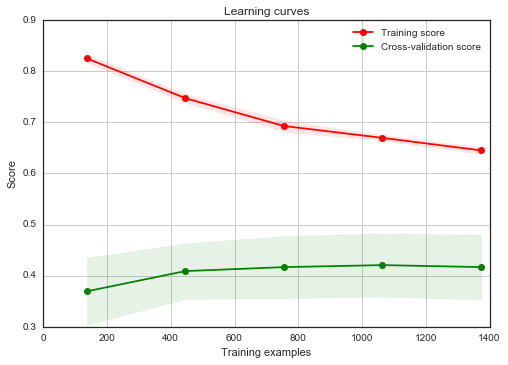

In [20]:
#Examine test characteristics (using same train and test sets)

#initializelabel(label='firms')

#best_maxdepth=5

#(HERE IS THE PLACE TO CHOOSE VISUALLY)
best_maxdepth_firms=best_maxdepth

clf_ = RandomForestRegressor(n_estimators=nestimators,max_depth=best_maxdepth)
clf_.fit(X_train, y_train)

clf1 = RandomForestRegressor(n_estimators=nestimators,max_depth=best_maxdepth)

viz(clf_,clf1)

Test score is 0.719880230112
Final score is 0.606542047848


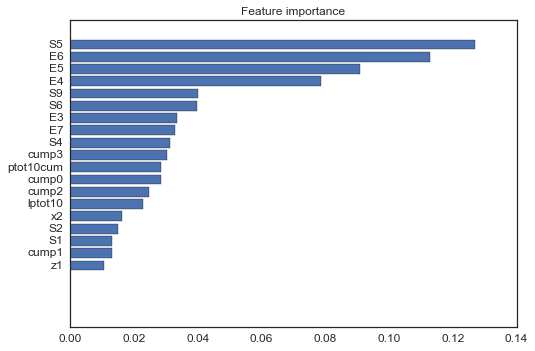

In [21]:
clf1 = RandomForestRegressor(n_estimators=nestimators,max_depth=best_maxdepth)
clf1.fit(X_test, y_test)
print("Test score is", clf1.score(X_test, y_test))

clf1.fit(X, y)
print("Final score is", clf1.score(X, y))

#Here is the predicted firm growth rate estimate
y1predict=clf1.predict(X)
aa = pd.DataFrame(y1predict)
aa.columns = ['firmgrowthregpred']
aa.to_csv("firmgrowthregpred.csv")
#aa.head()

#Here we obtain several measures for the estimator
val = featureImportance(X=XX, clf=clf1, threshold=0.01,return_=True)
aa = pd.DataFrame(val,index=['firmgrowthregimp'])
aa=aa.transpose()
aa.to_csv('FirmGrowthRegVarsImp.csv')

## Predict 2016-2020 firm growth rate

In [22]:
XX16=pd.merge(X116,X316,on = 'entmun')
XX16=XX16.set_index('entmun')
X16=XX16.as_matrix()

#Here is the predicted firm growth rate estimate
y116predict=clf1.predict(X16)
aa = pd.DataFrame(y116predict)
aa.columns = ['firmgrowthregpred1620']
aa.to_csv("firmgrowthregpred1620.csv")
aa.head()


,firmgrowthregpred1620
0,0.757660
1,0.182858
2,0.164911
3,0.113230
4,0.539500


# Now we estimate the  population growth rate 

## We also save predicted population growth rate and feature importance 

In [36]:
#the grid of parameters to search over
testsize=0.30
#nestimatorset=[1000]
nestimators=1000
maxdepthset=[3, 4, 5]

best_maxdepth=parameterfit(label='population',max_depthset=maxdepthset)

nestimators is  1000 , maxdepth is  3 , score is  0.218237550133
nestimators is  1000 , maxdepth is  4 , score is  0.238457430838
nestimators is  1000 , maxdepth is  5 , score is  0.242150569702
nestimators is  1000
maxscore is  0.242150569702
best_maxdepth is  5


Accuracy: 0.248647157304


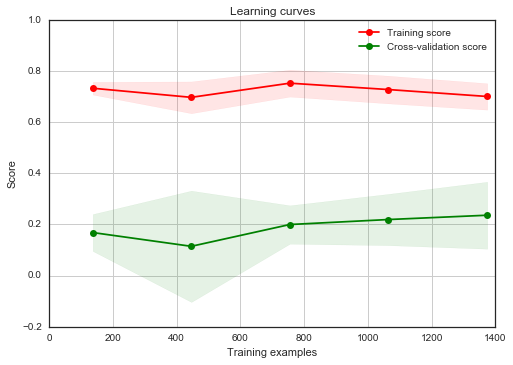

In [37]:
#Examine test characteristics (using same train and test sets)

#best_maxdepth=5

#(HERE IS THE PLACE TO CHOOSE VISUALLY)
best_maxdepth_pop=best_maxdepth

clf_ = RandomForestRegressor(n_estimators=nestimators,max_depth=best_maxdepth)
clf_.fit(X_train, y_train)

clf1 = RandomForestRegressor(n_estimators=nestimators,max_depth=best_maxdepth)

viz(clf_,clf1)

Test score is 0.545276185922
Final score is 0.642356973994


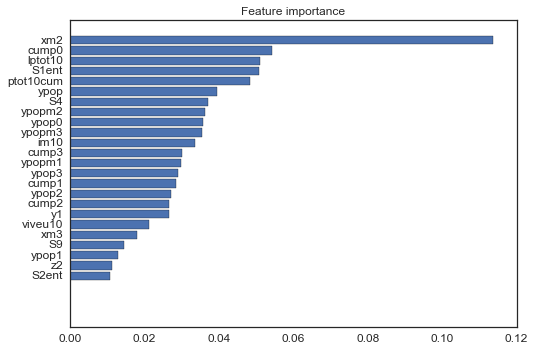

In [38]:
clf1 = RandomForestRegressor(n_estimators=nestimators,max_depth=best_maxdepth)
clf1.fit(X_test, y_test)
print("Test score is", clf1.score(X_test, y_test))

clf1.fit(X, y)
print("Final score is", clf1.score(X, y))

#Here is the predicted firm growth rate estimate
y2predict=clf1.predict(X)
aa = pd.DataFrame(y2predict)
aa.columns = ['popgrowthregpred']
aa.to_csv("popgrowthregpred.csv")
#aa.head()

#Here we obtain several measures for the estimator
val = featureImportance(X=XX, clf=clf1, threshold=0.01,return_=True)
aa = pd.DataFrame(val,index=['popgrowthregimp'])
aa=aa.transpose()
aa.to_csv('PopGrowthRegVarsImp.csv')

## Predict 2016-2020 population growth rate

In [39]:
XX16=pd.merge(X116,X316,on = 'entmun')
XX16=XX16.set_index('entmun')
X16=XX16.as_matrix()

#Here is the predicted firm growth rate estimate
y216predict=clf1.predict(X16)
aa = pd.DataFrame(y216predict)
aa.columns = ['popgrowthregpred1620']
aa.to_csv("popgrowthregpred1620.csv")
aa.head()


,popgrowthregpred1620
0,0.019518
1,0.010109
2,0.009713
3,0.011937
4,0.025717


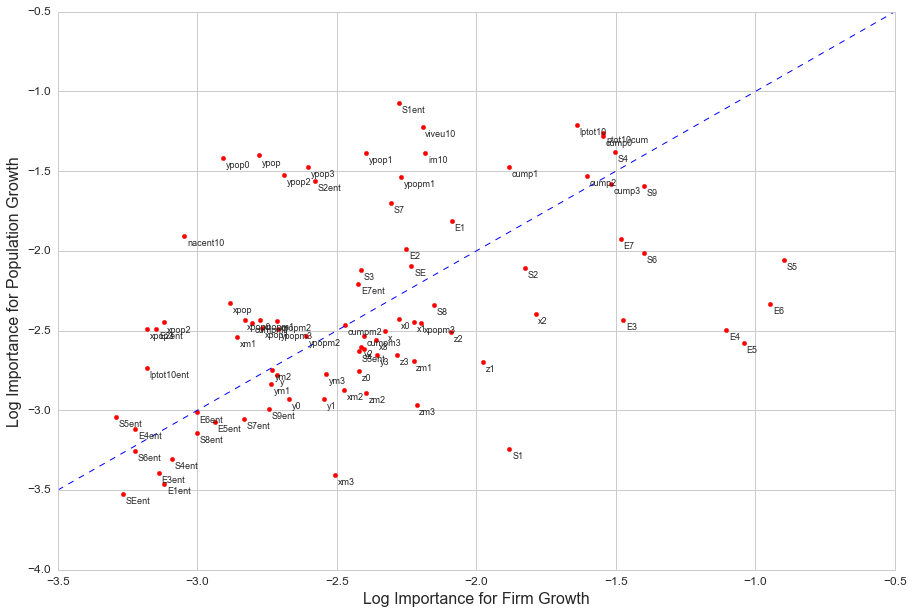

In [134]:
sns.set_style("whitegrid")
aa = pd.read_csv('FirmGrowthRegVarsImp.csv',index_col=0).reset_index()
bb = pd.read_csv('PopGrowthRegVarsImp.csv',index_col=0).reset_index()
aa=pd.merge(aa,bb)

aa.columns=['Variable','Firms','Population']
aa['LogFirmImportance']=np.where(aa['Firms']<0.00001, 0, np.log10(aa['Firms']))
aa['LogPopulationImportance']=np.where(aa['Population']<0.00001, 0, np.log10(aa['Population']))

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(aa.LogFirmImportance, aa.LogPopulationImportance,color='r')

for i, txt in enumerate(aa.Variable):
    ax.annotate(txt, (aa.iloc[i,3]+0.01,aa.iloc[i,4]-0.06),fontsize=9)

ax.set_xlim([-3.5, -0.5])
ax.set_ylim([-4.0, -0.5])

x = np.linspace(-3.5, -0.5)
y = np.linspace(-3.5, -0.5)

plt.plot(x,y, '--',color='b',linewidth=1.0)
plt.xlabel("Log Importance for Firm Growth",fontsize=16)
plt.ylabel("Log Importance for Population Growth",fontsize=16)
plt.tick_params(labelsize=12)
plt.show()



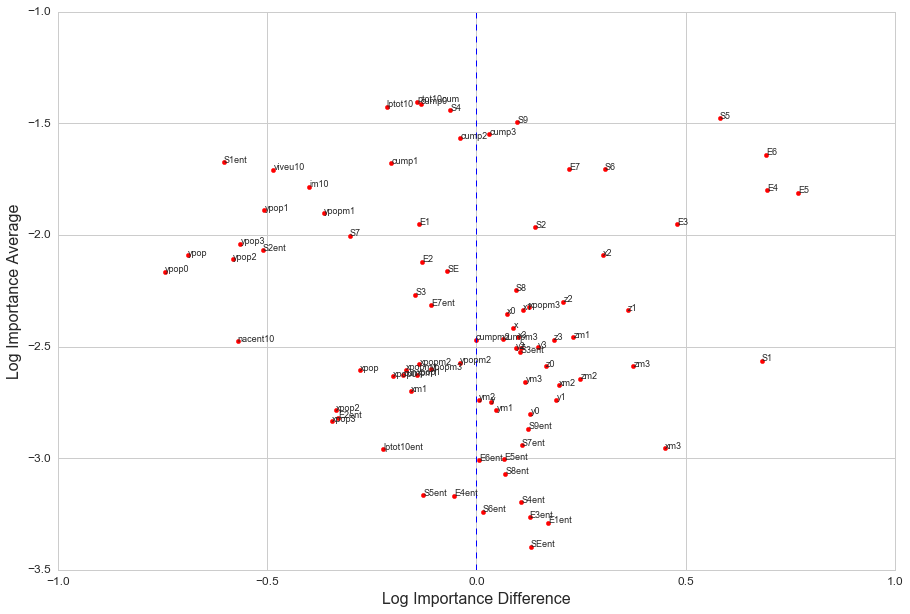

In [133]:
sns.set_style("whitegrid")
aa = pd.read_csv('FirmGrowthRegVarsImp.csv',index_col=0).reset_index()
bb = pd.read_csv('PopGrowthRegVarsImp.csv',index_col=0).reset_index()
aa=pd.merge(aa,bb)

aa.columns=['Variable','Firms','Population']

aa['LogFirmImportance']=np.where(aa['Firms']<0.00001, 0, np.log10(aa['Firms']))
aa['LogPopulationImportance']=np.where(aa['Population']<0.00001, 0, np.log10(aa['Population']))

#aa['LogFirmImportance']=np.where(aa['Firms']<0.01, 2.01+np.log10(aa['Firms']), aa['Firms'])
#aa['LogPopulationImportance']=np.where(aa['Population']<0.01, 2.01+np.log10(aa['Population']), aa['Population'])

aa['AverageLogImportance']=(aa['LogFirmImportance']+aa['LogPopulationImportance'])/2
aa['ImportanceLogDifference']=(aa['LogFirmImportance']-aa['LogPopulationImportance'])/2

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(aa.ImportanceLogDifference,aa.AverageLogImportance,color='r')

aa.head()
for i, txt in enumerate(aa.Variable):
    ax.annotate(txt, (aa.iloc[i,6]+0.0004,aa.iloc[i,5]-0.0004),fontsize=9)

#ax.set_xlim([-3.5, -0.5])
ax.set_ylim([-3.5, -1])

x = np.linspace(0, 0)
y = np.linspace(-3.5, -1)

plt.plot(x,y, '--',color='b',linewidth=1.0)
plt.xlabel("Log Importance Difference",fontsize=16)
plt.ylabel("Log Importance Average",fontsize=16)
plt.tick_params(labelsize=12)
plt.show()



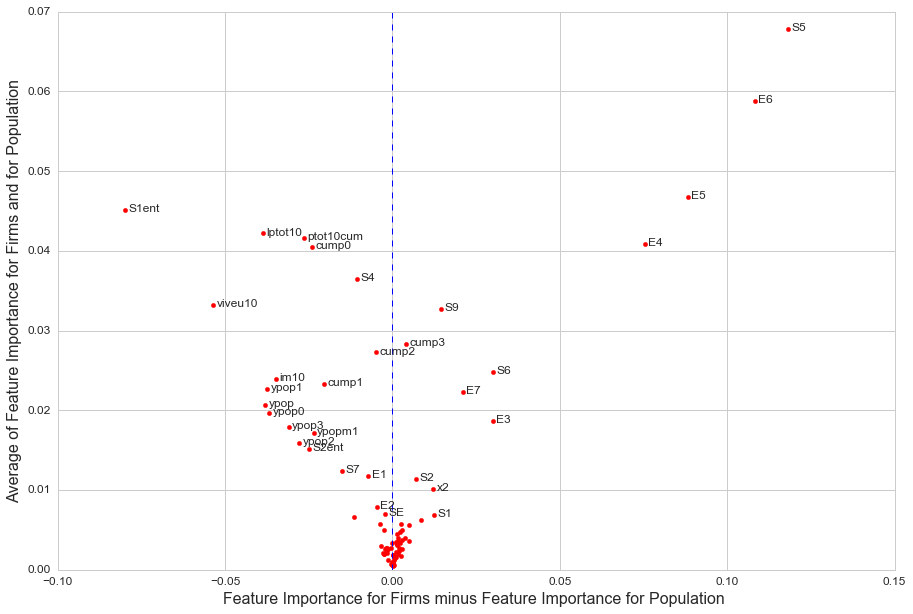

In [132]:
sns.set_style("whitegrid")
aa = pd.read_csv('FirmGrowthRegVarsImp.csv',index_col=0).reset_index()
bb = pd.read_csv('PopGrowthRegVarsImp.csv',index_col=0).reset_index()
aa=pd.merge(aa,bb)

aa.columns=['Variable','Firms','Population']

aa['AverageImportance']=(aa['Firms']+aa['Population'])/2
aa['ImportanceDifference']=(aa['Firms']-aa['Population'])

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(aa.ImportanceDifference,aa.AverageImportance,color='r')

aa.head()
for i, txt in enumerate(aa.Variable):
    if aa.iloc[i,3] >0.00675 :
        ax.annotate(txt, (aa.iloc[i,4]+0.001,aa.iloc[i,3]-0.0002),fontsize=12)

ax.set_xlim([-0.1, 0.15])
ax.set_ylim([0, 0.07])

x = np.linspace(0, 0)
y = np.linspace(0, 0.07)

plt.plot(x,y, '--',color='b',linewidth=1.0)
plt.xlabel("Feature Importance for Firms minus Feature Importance for Population ",fontsize=16)
plt.ylabel("Average of Feature Importance for Firms and for Population",fontsize=16)
plt.tick_params(labelsize=12)
plt.show()



In [41]:
aa=XX['E1'].reset_index()
for name in ['firmgrowthregpred','popgrowthregpred','firmgrowthregpred1620','popgrowthregpred1620'] :
    bb = pd.read_csv(name+'.csv',index_col=0)
    aa[name]=bb

aa['y1']=y1
aa['y2']=y2
aa['resfirms']=aa['firmgrowthregpred']-y1
aa['respop']=aa['popgrowthregpred']-y2

aa=aa.drop('E1', 1)
aa.to_csv('prediccionesreg.csv')
prediccionesreg=aa
prediccionesreg.describe()

,entmun,firmgrowthregpred,popgrowthregpred,firmgrowthregpred1620,popgrowthregpred1620,y1,y2,resfirms,respop
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000
mean,19365.572301,0.105081,0.007011,0.169642,0.011559,0.105128,0.007020,-0.000047,-0.000009
std,7362.851174,0.143637,0.013377,0.127362,0.008215,0.209669,0.021720,0.131517,0.012989
min,1001.000000,-0.181911,-0.041136,0.023984,-0.009163,-0.578151,-0.084055,-0.983192,-0.194857
25%,14083.500000,0.016378,0.000285,0.100769,0.005601,-0.016097,-0.001297,-0.062982,-0.005985
50%,20230.000000,0.057630,0.009590,0.110084,0.011813,0.048254,0.008017,0.010009,0.000234
75%,24030.500000,0.128820,0.012733,0.176430,0.016001,0.159489,0.015289,0.069648,0.006864
max,32058.000000,1.084196,0.441568,0.970574,0.078651,2.052741,0.636425,0.501433,0.055611


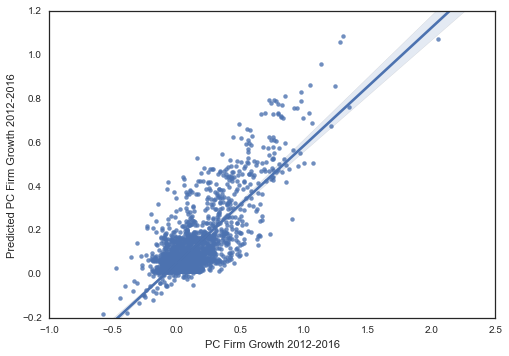

In [135]:
sns.set_style("white")
ax=sns.regplot(x="y1", y="firmgrowthregpred", data=prediccionesreg)
ax.set_xlim([-1.0, 2.5])
ax.set_ylim([-0.2, 1.2])
plt.xlabel('PC Firm Growth 2012-2016')
plt.ylabel('Predicted PC Firm Growth 2012-2016')

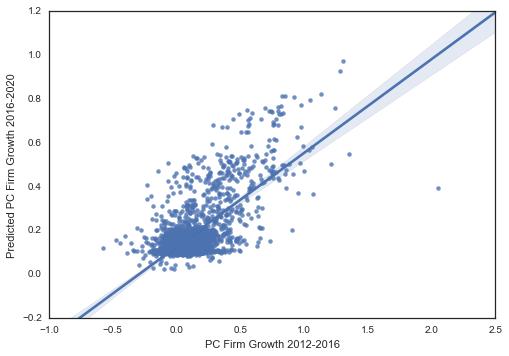

In [70]:
ax=sns.regplot(x="y1", y="firmgrowthregpred1620", data=prediccionesreg)
ax.set_xlim([-1.0, 2.5])
ax.set_ylim([-0.2, 1.2])
plt.xlabel('PC Firm Growth 2012-2016')
plt.ylabel('Predicted PC Firm Growth 2016-2020')

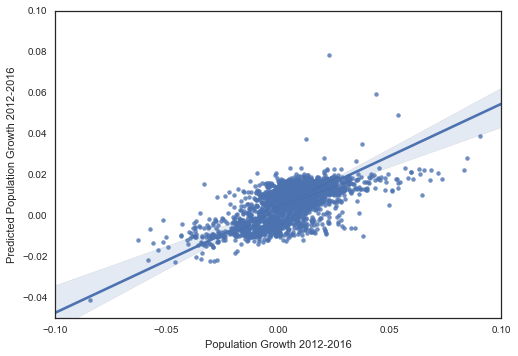

In [81]:
ax=sns.regplot(x="y2", y="popgrowthregpred", data=prediccionesreg)
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.05, 0.1])
plt.xlabel('Population Growth 2012-2016')
plt.ylabel('Predicted Population Growth 2012-2016')

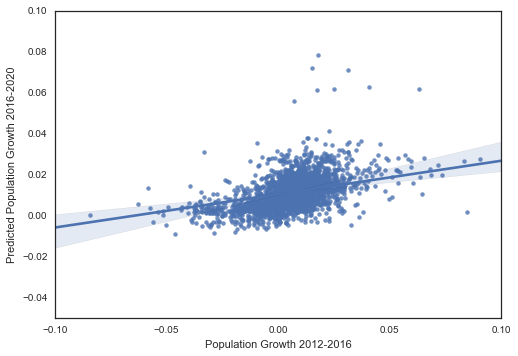

In [82]:
ax=sns.regplot(x="y2", y="popgrowthregpred1620", data=prediccionesreg)
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.05, 0.1])
plt.xlabel('Population Growth 2012-2016')
plt.ylabel('Predicted Population Growth 2016-2020')

In [73]:
prediccionesreg[['y1','firmgrowthregpred','firmgrowthregpred1620','y2','popgrowthregpred','popgrowthregpred1620']].describe()

,y1,firmgrowthregpred,firmgrowthregpred1620,y2,popgrowthregpred,popgrowthregpred1620
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000
mean,0.105128,0.105081,0.169642,0.007020,0.007011,0.011559
std,0.209669,0.143637,0.127362,0.021720,0.013377,0.008215
min,-0.578151,-0.181911,0.023984,-0.084055,-0.041136,-0.009163
25%,-0.016097,0.016378,0.100769,-0.001297,0.000285,0.005601
50%,0.048254,0.057630,0.110084,0.008017,0.009590,0.011813
75%,0.159489,0.128820,0.176430,0.015289,0.012733,0.016001
max,2.052741,1.084196,0.970574,0.636425,0.441568,0.078651


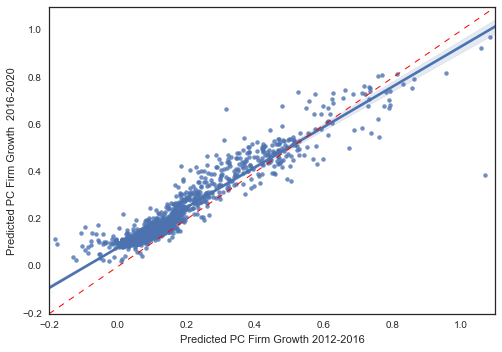

In [141]:
ax=sns.regplot(x="firmgrowthregpred", y="firmgrowthregpred1620", data=prediccionesreg)
ax.set_xlim([-0.2, 1.1])
ax.set_ylim([-0.2, 1.1])

x = np.linspace(-0.2, 1.1)
y = np.linspace(-0.2, 1.1)

plt.plot(x,y, '--',color='r',linewidth=1.0)

plt.xlabel('Predicted PC Firm Growth 2012-2016')
plt.ylabel('Predicted PC Firm Growth  2016-2020')

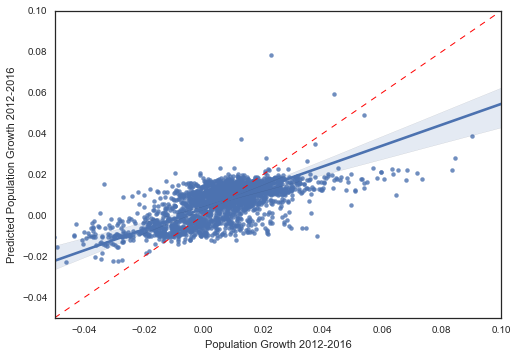

In [142]:
ax=sns.regplot(x="y2", y="popgrowthregpred", data=prediccionesreg)
ax.set_xlim([-0.05, 0.1])
ax.set_ylim([-0.05, 0.1])

x = np.linspace(-0.05, 0.1)
y = np.linspace(-0.05, 0.1)

plt.plot(x,y, '--',color='r',linewidth=1.0)


plt.xlabel('Population Growth 2012-2016')
plt.ylabel('Predicted Population Growth 2012-2016')

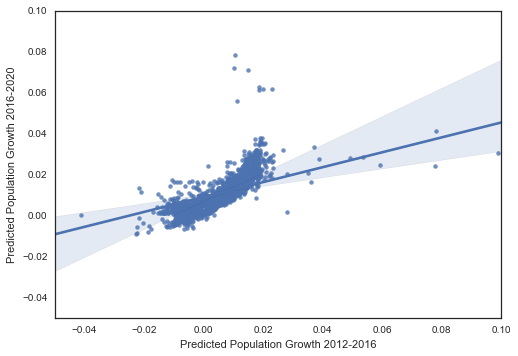

In [49]:
ax=sns.regplot(x="popgrowthregpred", y="popgrowthregpred1620", data=prediccionesreg)
ax.set_xlim([-0.05, 0.1])
ax.set_ylim([-0.05, 0.1])
plt.xlabel('Predicted Population Growth 2012-2016')
plt.ylabel('Predicted Population Growth 2016-2020')

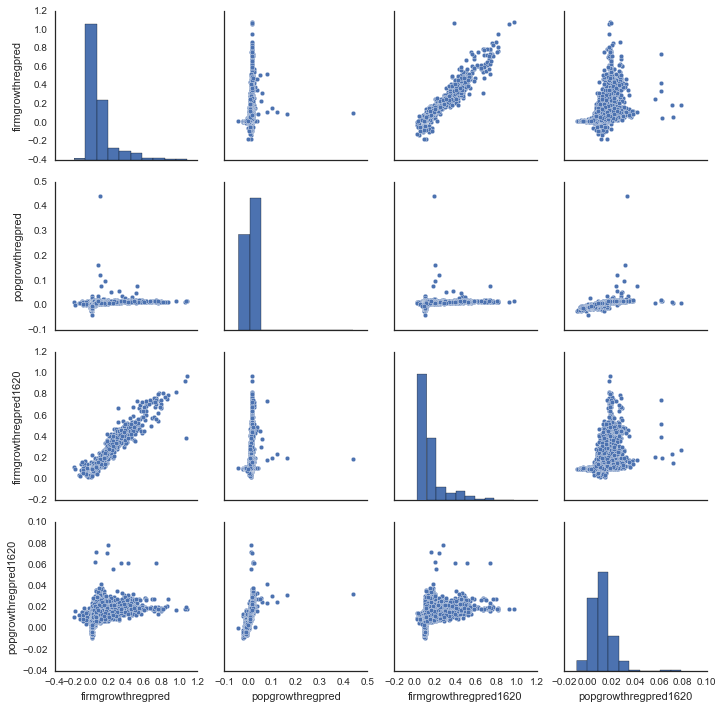

In [42]:
sns.set(style="white")
sns.pairplot(prediccionesreg,vars=['firmgrowthregpred','popgrowthregpred','firmgrowthregpred1620','popgrowthregpred1620'])

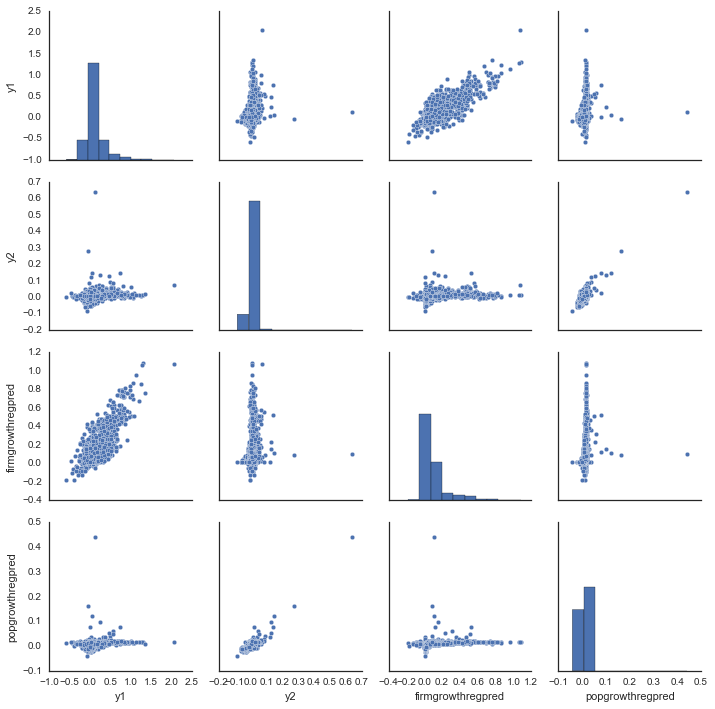

In [43]:
sns.set(style="white")
sns.pairplot(prediccionesreg,vars=['y1','y2','firmgrowthregpred','popgrowthregpred'])
